<a href="https://colab.research.google.com/github/kundajelab/locusselect/blob/master/examples/regression%20on%20200%20bp%20genome%20bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model 
import tensorflow
from tensorflow.compat.v1.keras.backend import get_session
tensorflow.compat.v1.disable_v2_behavior()
import kerasAC 
from kerasAC.generators.tiledb_predict_generator import *
from kerasAC.tiledb_config import *
import tiledb 
from scipy.special import softmax
from kerasAC.interpret.deepshap import * 
from kerasAC.interpret.profile_shap import * 
from kerasAC.vis import *
from kerasAC.custom_losses import * 
from kerasAC.metrics import * 


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


/users/annashch/kerasAC/kerasAC/vis/plot_letters.py:173: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/users/annashch/kerasAC/kerasAC/vis/plot_letters.py:174: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [2]:
## for plotting 
%matplotlib inline

import matplotlib 
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,5
plt.rcParams['axes.xmargin'] = 0

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

In [3]:
custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "MultichannelMultinomialNLL":MultichannelMultinomialNLL}
get_custom_objects().update(custom_objects)


In [4]:
model=load_model("/srv/scratch/annashch/deeplearning/profile/k562_h3k27ac/6kb/k562.h3k27ac.seed.1234.cs.25.filters.500.naive.range.4.6.to.11.5.0.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 6000, 4)      0                                            
__________________________________________________________________________________________________
1st_conv (Conv1D)               (None, 5980, 300)    25500       sequence[0][0]                   
__________________________________________________________________________________________________
1stconv-crop_1th_dconv (Croppin (None, 5976, 300)    0           1st_conv[0][0]                   
__________________________________________________________________________________________________
0_dilconv (Conv1D)              (None, 5976, 300)    270300      1st_conv[0][0]                   
____________________________________________________________________________________________

In [6]:
import shap
from kerasAC.interpret.profile_shap import * 
model_wrapper=(model.input, model.layers[-1].output)
count_explainer=shap.DeepExplainer(model_wrapper,data=create_background,combine_mult_and_diffref=combine_mult_and_diffref)
prof_explainer = create_explainer(model)


HERE--tf
HERE--keras

here!
here!


In [7]:
import pysam 
ref=pysam.FastaFile("/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")
flank=3000
scramble_flank=75
out_flank=500
import tiledb 
db=tiledb.open("/srv/scratch/annashch/encode_dnase_tiledb/db/histone",'r')

In [8]:
regions=[i.split('\t') for i in open("/srv/scratch/annashch/deeplearning/profile/k562_dnase/bpnet/interpret/regions_to_score.bed",'r').read().strip().split('\n')]

(778215, 779215)
(1, 1000, 2)


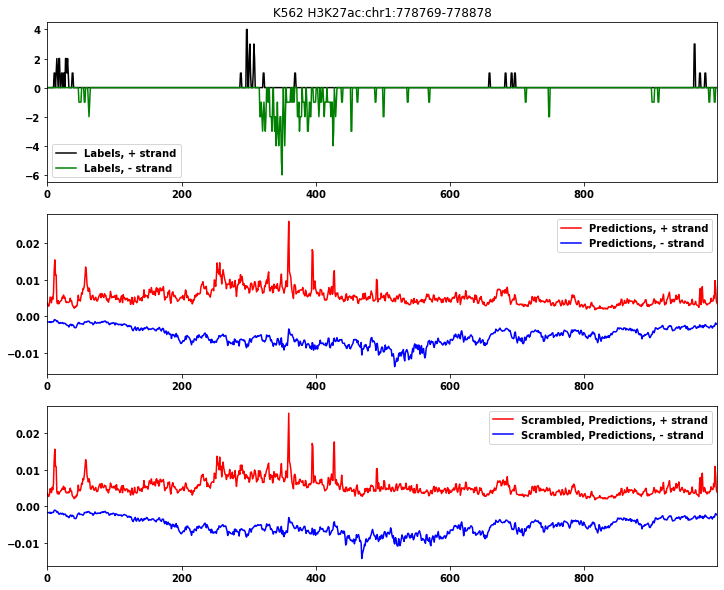

In [20]:
for region in regions[11:12]: 
    chrom=region[0] 
    start=int(region[1])
    end=int(region[2])
    center=start+int((start-end)/2)
    region_start=center-flank 
    region_end=center+flank 
    scramble_start=flank-scramble_flank 
    scramble_end=flank+scramble_flank 
    seq=ref.fetch(chrom,region_start,region_end)
    #scramble_start=3700
    #scramble_end=3800
    scrambled_seq=seq[0:scramble_start]+dinuc_shuffle(seq[scramble_start:scramble_end])+seq[scramble_end::]
    seq_onehot=one_hot_encode([seq])
    scrambled_onehot=one_hot_encode([scrambled_seq])
    output_start_coord=center-out_flank 
    output_end_coord=center+out_flank 
    tdb_indices=coords_to_tdb_indices((chrom,output_start_coord,output_end_coord),db)
    print(tdb_indices)
    control_profile_plus=db[tdb_indices[0]:tdb_indices[1]]['control_count_bigwig_plus_5p']
    control_profile_minus=db[tdb_indices[0]:tdb_indices[1]]['control_count_bigwig_minus_5p']
    control_profile=np.concatenate((control_profile_plus,control_profile_minus),axis=-1)
    control_profile=np.expand_dims(control_profile,axis=0)
    print(control_profile.shape)
    control_sum_plus=np.expand_dims(np.array(np.log(np.sum(control_profile_plus))),axis=0)
    control_sum_minus=np.expand_dims(np.array(np.log(np.sum(control_profile_minus))),axis=0)
    control_sum=np.concatenate((control_sum_plus,control_sum_minus),axis=-1)
    control_sum=np.expand_dims(control_sum,axis=0)
    X=[seq_onehot,control_profile,control_sum]
    X_scrambled=[scrambled_onehot,control_profile,control_sum]

    pred=model.predict(X)
    pred_0=pred[0]
    pred_1=pred[1]
    pred_0_softmax=softmax(pred_0,axis=1)
    
    pred_scrambled=model.predict(X_scrambled)
    pred_0_scrambled=pred_scrambled[0]
    pred_1_scrambled=pred_scrambled[1]
    pred_0_softmax_scrambled=softmax(pred_0_scrambled,axis=1)
    
    y_plus=db[tdb_indices[0]:tdb_indices[1]]['count_bigwig_plus_5p']
    y_minus=db[tdb_indices[0]:tdb_indices[1]]['count_bigwig_minus_5p']
    
    
    #profile_explanations=prof_explainer(seq_onehot,control_profile,control_sum)
    #profile_scrambled_explanations=prof_explainer(scrambled_onehot,control_profile,control_sum)
    cur_index=0
    
    counts_plus=pred_0_softmax[cur_index,:,0]*pred_1[cur_index,0]
    counts_plus_scrambled=pred_0_softmax_scrambled[cur_index,:,0]*pred_1_scrambled[cur_index,0]
    counts_minus=pred_0_softmax[cur_index,:,1]*pred_1[cur_index,1]
    counts_minus_scrambled=pred_0_softmax_scrambled[cur_index,:,1]*pred_1_scrambled[cur_index,1]
    
    

    plt.rcParams["figure.figsize"]=12,10
    fig, axes = plt.subplots(3, 1)
    axes[0].plot(y_plus,label='Labels, + strand',color='k')
    axes[0].plot(-1*y_minus,label='Labels, - strand',color='g')
    
    axes[1].plot(counts_plus,label='Predictions, + strand',color='r')
    axes[1].plot(-1*counts_minus,label='Predictions, - strand',color='b')
    
    
    axes[2].plot(counts_plus_scrambled,label='Scrambled, Predictions, + strand',color='r')
    axes[2].plot(-1*counts_minus_scrambled,label='Scrambled, Predictions, - strand',color='b')
    
    axes[0].set_title('K562 H3K27ac:'+chrom+":"+str(start)+"-"+str(end))
    axes[0].legend()
    axes[1].legend() 
    axes[2].legend()
    plt.show() 

    

In [14]:
pred_0_softmax.shape

(1, 1000, 2)